Install the dependency

In [ ]:
!pip3 install nltk

Util Function for clean up

In [385]:
import os
import re
import pandas as pd
import numpy as np


def extract_text_from_folder(folder_path,column_name="text"):
    text_data = []
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith(('.txt', '.rst')):
                file_path = os.path.join(root, file_name)
                with open(file_path, 'r', encoding='utf-8') as file:
                    text = file.read()
                    text_data.append(text)
       
    text_data_df = pd.DataFrame(np.array(text_data), columns=[column_name])
    return text_data_df

def clean_text_data(text_data):
    # Remove Markdown links
    text_data = re.sub(r'\:link_to_translation\:\`[^`]*\`', '', text_data)
    
    # Remove code blocks
    text_data = re.sub(r'```.*?```', '', text_data, flags=re.DOTALL)
    
    # Remove HTML tags
    text_data = re.sub(r'<[^>]+>', '', text_data)
    
    # Remove section headers
    text_data = re.sub(r'^=+\n.*\n=+\n', '', text_data, flags=re.MULTILINE)
    text_data = re.sub(r'^-+\n.*\n-+\n', '', text_data, flags=re.MULTILINE)
    
    # Remove bulleted lists
    text_data = re.sub(r'^\s*\*\s+.*\n', '', text_data, flags=re.MULTILINE)
    
    # Remove numbered lists
    text_data = re.sub(r'^\s*\d+\.\s+.*\n', '', text_data, flags=re.MULTILINE)
    #Remove special sequence
    text_data=re.sub(r'====+','',text_data) 
    text_data=re.sub(r'\^\^\^\^+','',text_data) 
    text_data=re.sub(r'----+','',text_data) 
    text_data=re.sub(r'\*\*\*\*\*+','',text_data) 
    # Remove indentation and empty lines
    # text_data = re.sub(r'^\s+', '', text_data, flags=re.MULTILINE)
    # text_data = re.sub(r'^\n', '', text_data, flags=re.MULTILINE)
    
    return text_data

Split the textual data into chunk

In [454]:

import pandas as pd
import nltk.data

# Load the NLTK sentence tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


def split_text(text, chunk_size=500):
    # Define regex pattern for identifying sentence endings
    sentence_endings = r'[.!?]'
    chunks = []
    current_chunk = ""
    current_length = 0
    for char in text:
        current_chunk += char
        current_length += 1
        if re.search(sentence_endings, char):
            if current_length >= chunk_size:
                chunks.append(current_chunk)
                current_chunk = ""
                current_length = 0
    if current_chunk:  # Append any remaining part
        chunks.append(current_chunk)
    return chunks

def split_dataframe_manual(df, column_name='text', chunk_size=500):
    new_rows = []
    for index, row in df.iterrows():
        text = row[column_name]
        chunks = split_text(text, chunk_size)
        for chunk in chunks:
            new_row = row.copy()
            new_row[column_name] = chunk
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)



Token distribution plotting

In [458]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(prompt["text"])

def plot_data_lengths(tokenized_train_dataset,column_name="text"):
    lengths = [len(x[column_name]) for x in tokenized_train_dataset]
    # lengths += [len(x['text_data']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()



In [386]:
text_data = extract_text_from_folder("./raw_dataset_USFTHF/docs/",column_name="text")
text_data


,text
0,Migration Guides\n*****************\n\n:link_t...
1,Migration from 5.0 to 5.1\n-------------------...
2,Networking\n===========\n\n:link_to_translatio...
3,GCC\n***\n\n:link_to_translation:`zh_CN:[中文]`\...
4,System\n======\n\n:link_to_translation:`zh_CN:...
...,...
362,====================\nESP-LyraP-LCD32 v1.1\n==...
363,==================\nESP-LyraP-CAM v1.1\n======...
364,==================\nESP-LyraP-CAM v1.0\n======...
365,====================\nESP-LyraP-LCD32 v1.2\n==...


In [390]:
clean_data = text_data.drop_duplicates()
clean_data = clean_data.map(clean_text_data)
clean_data.to_csv('clean_data.csv', index=False)
clean_data

,text
0,Migration Guides\n\n\n\n\nESP-IDF 5.x Migratio...
1,Migration from 5.0 to 5.1\n\n\n\n\n.. toctree:...
2,Networking\n\n\n\n\nSNTP\n\n\nSNTP module now ...
3,GCC\n***\n\n\n\n\nGCC Version\n\n\nThe previou...
4,System\n\n\n\n\nFreeRTOS\n\n\n.. only:: SOC_SP...
...,...
362,\n\n\nThis user guide provides information on ...
363,\n\n\nThis user guide provides information on ...
364,\n\n\nThis user guide provides information on ...
365,\n\n\nThis user guide provides information on ...


In [420]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(clean_data)
train_dataset= train_dataset.map()

Dataset({
    features: ['text', '__index_level_0__'],
    num_rows: 362
})

Map: 100%|██████████| 37842/37842 [00:03<00:00, 12505.63 examples/s]


37842


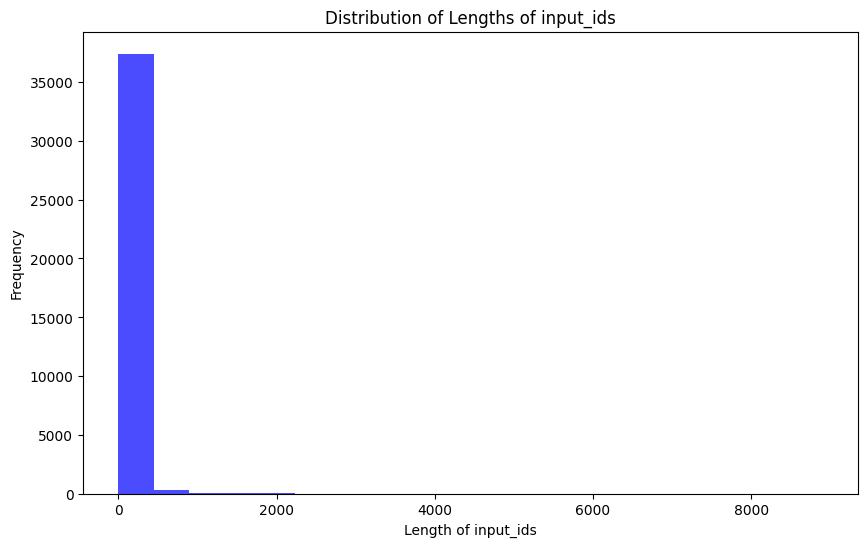

In [430]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
plot_data_lengths(tokenized_train_dataset)

In [456]:
# split_data=split_dataframe_manual(clean_data,column_name="text",max_chunk_size=1000,max_total_size=4000)
split_data=split_dataframe_manual(clean_data,column_name="text",chunk_size=1000)

split_data
train_dataset = Dataset.from_pandas(split_data)
train_dataset

Dataset({
    features: ['text', '__index_level_0__'],
    num_rows: 3001
})

In [475]:
split_data

,text
0,Migration Guides\n\n\n\n\nESP-IDF 5.x Migratio...
1,Migration from 5.0 to 5.1\n\n\n\n\n.. toctree:...
2,Networking\n\n\n\n\nSNTP\n\n\nSNTP module now ...
3,GCC\n***\n\n\n\n\nGCC Version\n\n\nThe previou...
3,There is an example of how it was fixed in ES...
...,...
366,\n\n\nRequired Hardware\n\n\n- ESP32-S2-DevKit...
366,. [#] The ESP32-S2-SOLO-2 and ESP32-S2-SOLO-2U...
366,. _user-guide-s2-devkitc-1-v1-header-blocks:\n...
366,Name Type Function\n=== \n1 G ...


Map: 100%|██████████| 3001/3001 [00:00<00:00, 3329.95 examples/s]


3001


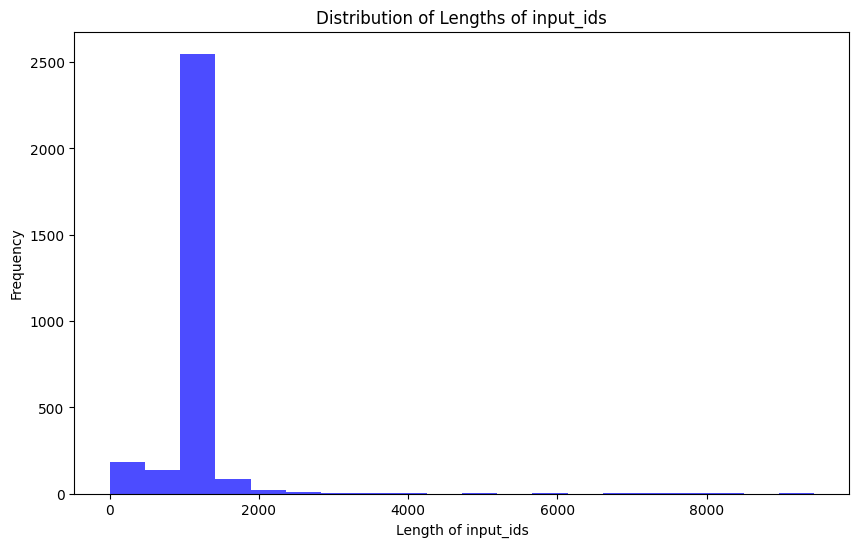

In [476]:

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
plot_data_lengths(tokenized_train_dataset)


In [461]:
train_dataset.push_to_hub("gouthamsk/esp_idf_text",split="train")



Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


CommitInfo(commit_url='https://huggingface.co/datasets/gouthamsk/esp_idf_text/commit/c2ce874b7c5a55a0bae6794bef7ce94d28133cbd', commit_message='Upload dataset', commit_description='', oid='c2ce874b7c5a55a0bae6794bef7ce94d28133cbd', pr_url=None, pr_revision=None, pr_num=None)

In [472]:
filtered_dataset

[['t', 'e', 'x', 't']]

In [ ]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(new_df)
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

In [ ]:
tokenized_train_dataset

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
# Drop duplicate rows across all columns

train_data, test_data = train_test_split(new_df, test_size=0.1)


In [ ]:
tokenized_train_dataset = split_train_data.map(generate_and_tokenize_prompt)

In [ ]:
train_dataset = Dataset.from_pandas(split_train_data)
train_dataset.push_to_hub("gouthamsk/esp_idf_text",split="train")

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
# Drop duplicate rows across all columns
new_df = new_df.drop_duplicates()
train_data, test_data = train_test_split(new_df, test_size=0.2)
train_dataset = Dataset.from_pandas(train_data)
eval_dataset = Dataset.from_pandas(test_data)

In [ ]:
test_data

In [ ]:

train_dataset.push_to_hub("gouthamsk/esp_idf_text",split="train")
eval_dataset.push_to_hub("gouthamsk/esp_idf_text",split="test")

In [ ]:

train_dataset,eval_dataset

In [ ]:

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)


Bellow Code is to clean up code dataset
